# Lab One: Exploring Table Data
Team: Jack Babcock, Hayden Center, Fidelia Navar, Amory Weinzierl

### Assignment Description
You are to perform preprocessing and exploratory analysis of a data set: exploring the statistical summaries of the features, visualizing the attributes, and addressing data quality. This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output.

Additional information and requirements can be found at https://smu.instructure.com/courses/81978/assignments/465788

## Part I -  Business Understanding

The data set (which can be found at https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) that we have chosen to utilize for this lab consists of data that may be used to identify whether or not an individual is at risk for strokes. 

## Part II - Data Understanding

### Data Description

#### Importing

In [ ]:
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df.head()

#### Formatting

To clean up the data a little bit, we're going to normalize the values of the non-numeric columns to have the same format by setting all values to lowercase and replacing spaces with underscores.

In [ ]:
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].str.lower()
        
df = df.replace(' ', '_', regex=True)
        
for c in df.columns:
    if df[c].dtype == 'object':
        print(df[c].unique())

All of the columns look good except for the smoking_status column. One of the values in that column is listed as 'unknown'. Though this is technically a value, what it is actually representing is missing information, so let's make that more clear.

In [ ]:
df.smoking_status.mask(df.smoking_status == 'unknown', pd.NA, inplace=True)

print(df.info())

Some of the categorical columns should be converted into numerical columns. Specifically the ever_married column should be converted into a binary column similar to the hypertension, heart_disease, and stroke columns, and the smoking_status column should be converted into an ordinal. We think this is a meaningful change because there is a very clear way to assign an order to the values: never_smoked is 0, formerly_smoked is 1 since it is worse for your health, and finally smokes is 2, since it is worse than formerly_smoked.

In [ ]:
df.smoking_status.replace(to_replace= ['never_smoked', 'formerly_smoked', 'smokes'], value = [0, 1, 2], inplace=True)
df.info()

### Data Quality

#### Duplicate Values

The first thing we'll want to do to check the quality of the data is to check for duplicates. First, let's make sure there are no duplicate IDs in the dataset.

In [ ]:
if df.id.unique().size == df.id.size:
    print("No duplicate IDs")

Now that we know there are no duplicate IDs, let's check if there are any rows with identical values (excluding the ID).

In [ ]:
cols = df.columns.drop('id')

s = df.duplicated(subset=cols, keep='first')

s[s]

Seems like the dataset has no exact duplicates. We feel safe assuming that, finding no exact duplicates, each entry in the dataset is unique.

#### Missing Values

The second thing to check the dataset for is missing values. We can see them by checking df.info().

In [ ]:
df.info()

Now we can see how much data is really missing from this dataset. We have over 1500 missing datapoints from the smoking_status column. Now let's take a look at both of the columns with missing data and see if we want to impute or delete them.

In [ ]:
from sklearn.impute import KNNImputer
import copy

knn = KNNImputer(n_neighbors=3)

temp = df[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]].to_numpy()

temp_imputed = knn.fit_transform(temp)

df_imputed = copy.deepcopy(df)
df_imputed[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]] = temp_imputed
# df_imputed.info()

df_imputed.bmi = df_imputed.bmi.apply(lambda x: round(x, 1))

print(df_imputed.count())

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

df_imputed.bmi.plot(kind='hist', alpha=0.5, label="imputed",bins=100)
df.bmi.plot(kind='hist', alpha=0.5, label="original",bins=100)
plt.legend()
plt.show()

## Part III - Data Visualization

### Visualize basic feature distributions (5 plots).


In [ ]:
import seaborn as sns
# plt.subplots(figsize=(20, 5))
# plt.subplot(1,3,1)
# sns.boxplot(x="hypertension", y="age", data=df_imputed)

# plt.title('Age / Hypertension Correlation')
# plt.ylabel('Age')
# plt.xlabel('Hypertension')

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Comparing Age to Various Health Conditions')

# Bulbasaur
sns.boxplot(ax = axes[0], x="hypertension", y="age", data=df_imputed)
axes[0].set_title('Age / Hypertension')

# # Charmander
# sns.boxplot(ax = axes[1], x="heart_disease", y="age", data=df_imputed)
# axes[1].set_title('Age/ Heart Disease')

# # Squirtle
# sns.boxplot(ax = axes[2], x="smoking_status", y="age", data=df_imputed)
# axes[2].set_title('Age / Smoking Status')

# sns.boxplot(ax = axes[3], x="avg_glucose_level", y="age", data=df_imputed)
# axes[3].set_title('Age / Glucose Level')

<AxesSubplot:xlabel='heart_disease', ylabel='age'>

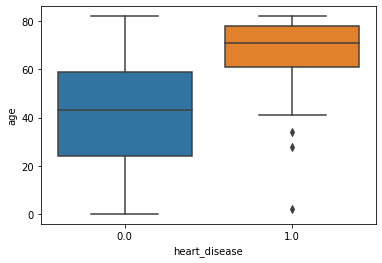

In [201]:
sns.boxplot(x="heart_disease", y="age", data=df_imputed)

<AxesSubplot:xlabel='stroke', ylabel='age'>

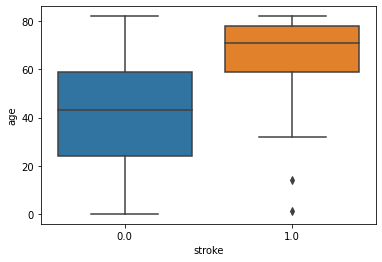

In [203]:
sns.boxplot(x="stroke", y="age", data=df_imputed)


This boxplot represents the distribution of people who live in urban/rural areas and if they have had a stroke or not. This plot is interesting to analyze because the 25th percentile of both groups who had strokes happen above the age of 60, regardless of what type of environment they lived in. This can help conclude that residency type does not directly contribute to the likelihood of having a stroke.

stroke                         False      True 
hypertension ever_married                      
0.0          no            98.943662   1.056338
             yes           94.325997   5.674003
1.0          no            79.245283  20.754717
             yes           87.640449  12.359551

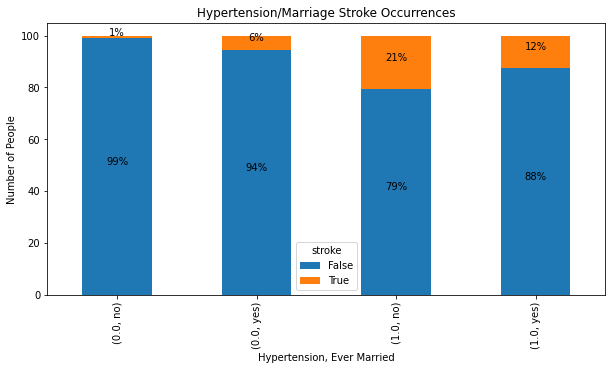

In [187]:
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
# let's manipulate the example to serve our purposes

ax= pd.crosstab([df_imputed['hypertension'],df_imputed['ever_married']], df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_ = ax.plot.bar(figsize=(10,5),stacked=True)
display(ax)

for rec in ax_.patches:
    height = rec.get_height()
    ax_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
    
plt.title('Hypertension/Marriage Stroke Occurrences')
plt.xlabel('Hypertension, Ever Married')
plt.ylabel('Number of People')
plt.show()

This visual was used to understand the relationship between individuals having hypertension, ever being married, and having a stroke. We can see how people who have never been married had the lowest percentage of strokes, whereas those who had been married before had higher stroke counts.

<plot 3>

<plot 4>

<plot 5>

### Ask three interesting questions that are relevant to your dataset and explore visuals that help answer these questions. Use whichever visualization method is appropriate for your data. Important: Interpret the implications for each visualization.

**Question 1: What is more influential feature for stroke likelihood: hypertension, heart disease, or smoking status?**

stroke,False,True
hypertension,,
0.0,96.032090,3.967910
1.0,86.746988,13.253012


stroke,False,True
heart_disease,,
0.0,95.821266,4.178734
1.0,82.971014,17.028986


stroke,False,True
smoking_status,,
0,95.243129,4.756871
1,92.090395,7.909605
2,94.676806,5.323194


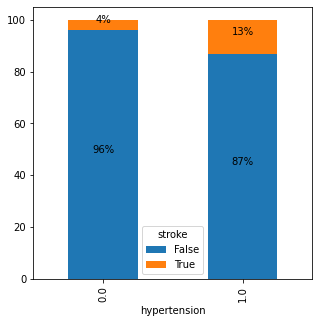

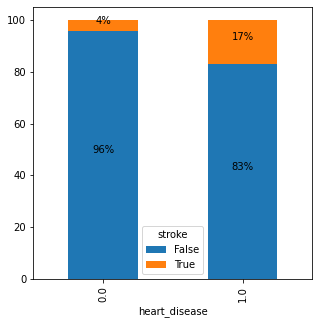

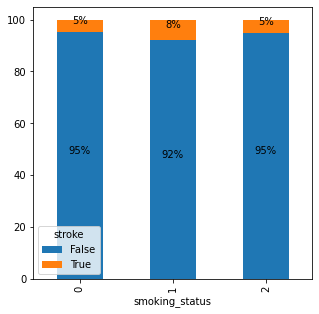

In [195]:
# plot overall cross tab with both groups

import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

# plt.figure(figsize=(15,3))
# ax1 = plt.subplot(1,3,1)
# ax2 = plt.subplot(1,3,2)
# ax3 = plt.subplot(1,3,3)

ax1= pd.crosstab([df_imputed['hypertension']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax1.plot.bar(figsize=(5,5),stacked=True)
# display(ax1)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

ax2= pd.crosstab([df_imputed['heart_disease']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_2 = ax2.plot.bar(figsize=(5,5),stacked=True)
# display(ax2)

for rec in ax_2.patches:
    height = rec.get_height()
    ax_2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

ax3 = pd.crosstab([df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_3 = ax3.plot.bar(figsize=(5,5),stacked=True)
# display(ax3)

display(ax1, ax2, ax3)
for rec in ax_3.patches:
    height = rec.get_height()
    ax_3.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

By observing the percentages on each chart, we can see how there was about 13 and 17% of individuals with hypertension and heart disease, respectively, who also had a stroke. The values for smoking status are lower. Therefore, we can conclude that heart disease was probably the strongest influencing factor for the likelihood of a stroke, compared to the other two health conditions.

**Question 2: Does the combination of different health conditions indicate a higher likelihood of having a stroke?**

stroke                          False      True 
hypertension heart_disease                      
0.0          0.0            96.613636   3.386364
             1.0            83.962264  16.037736
1.0          0.0            87.788018  12.211982
             1.0            79.687500  20.312500

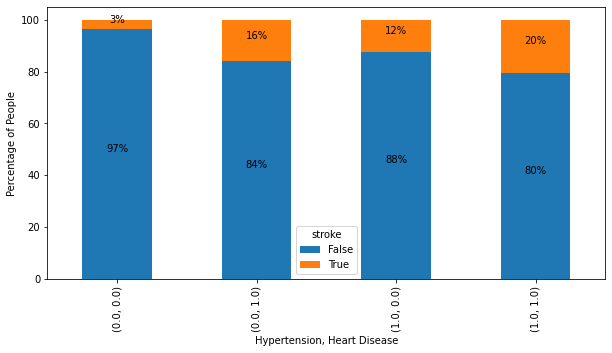

In [178]:
# plot overall cross tab with both groups

ax1= pd.crosstab([df_imputed['hypertension'], df_imputed['heart_disease']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax1.plot.bar(figsize=(10,5),stacked=True)
display(ax1)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
    
plt.ylabel('Percentage of People')
plt.xlabel('(Hypertension, Heart Disease)')

plt.show()

stroke                           False      True 
hypertension smoking_status                      
0.0          0               96.506024   3.493976
             1               93.333333   6.666667
             2               95.539568   4.460432
1.0          0               86.206897  13.793103
             1               84.166667  15.833333
             2               88.297872  11.702128

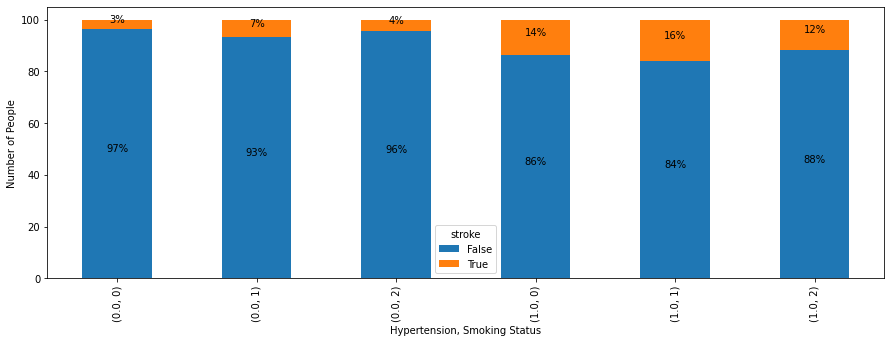

In [179]:
ax2= pd.crosstab([df_imputed['hypertension'], df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_2 = ax2.plot.bar(figsize=(15,5),stacked=True)
display(ax2)

for rec in ax_2.patches:
    height = rec.get_height()
    ax_2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.ylabel('Number of People')
plt.xlabel('(Hypertension, Smoking Status)')

plt.show()

stroke                           False      True 
hypertension smoking_status                      
0.0          0               96.506024   3.493976
             1               93.333333   6.666667
             2               95.539568   4.460432
1.0          0               86.206897  13.793103
             1               84.166667  15.833333
             2               88.297872  11.702128

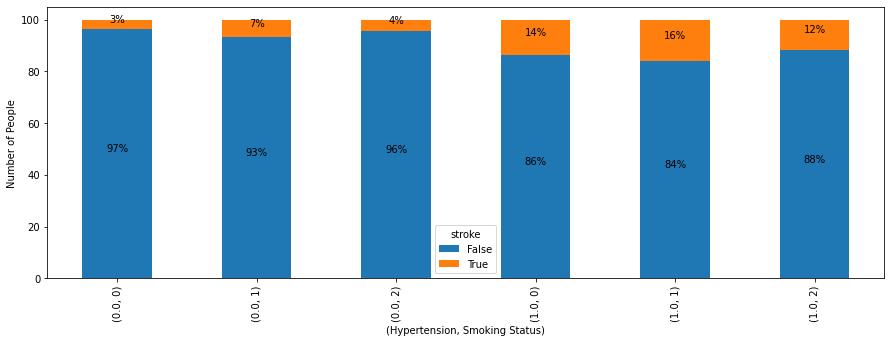

In [180]:
ax3= pd.crosstab([df_imputed['hypertension'], df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_3 = ax3.plot.bar(figsize=(15,5),stacked=True)
display(ax3)

for rec in ax_3.patches:
    height = rec.get_height()
    ax_3.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.ylabel('Number of People')
plt.xlabel('(Hypertension, Smoking Status)')

plt.show()

Once again, the visuals indicate that the combination of health conditions do not necessarily indicate the likelihood of a stroke. In fact, the largest number of strokes came from individuals who had no other health condition. This is useful to analyze because we can understand if certain health issues do/do not have a direct impact on prediction of a stroke.

**Question 3:**

## Part IV - Exceptional Work